# 07. Elastic Net Model

**Mô hình:** Elastic Net (L1 + L2 regularization)

**Thư viện:** sklearn.linear_model.ElasticNet

**Metrics:** RMSFE, MAPE

In [22]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Cấu hình hiển thị
import warnings
warnings.filterwarnings("ignore")
print("Đã nhập thư viện thành công.")

Đã nhập thư viện thành công.


In [23]:
# Đọc dữ liệu từ file CSV
# Đảm bảo các file 'train_clean.csv' và 'test_clean.csv' nằm cùng thư mục với notebook này
try:
    df_train = pd.read_csv('../data/processed/train_clean.csv')
    df_test = pd.read_csv('../data/processed/test_clean.csv')
    print("Đã tải dữ liệu thành công.")
except FileNotFoundError:
    print("Lỗi: Không tìm thấy file 'train_clean.csv' hoặc 'test_clean.csv'. Vui lòng kiểm tra lại đường dẫn.")
    # Tạo DataFrame rỗng để tránh lỗi tiếp theo
    df_train = pd.DataFrame() 
    df_test = pd.DataFrame()
    
# Nếu dữ liệu đã tải thành công, tiến hành phân chia X, y
if not df_train.empty and not df_test.empty:
    # Giả định cột đầu tiên 'Core CPI' là biến phụ thuộc (y)
    target_col = df_train.columns[0]
    feature_cols = df_train.columns.drop(target_col)

    # Phân chia X và y cho tập Train và Test
    X_train = df_train[feature_cols].copy()
    y_train = df_train[target_col].copy()

    X_test = df_test[feature_cols].copy()
    y_test = df_test[target_col].copy()
    
    print(f"Biến mục tiêu: {target_col}")
    print(f"Kích thước X_train: {X_train.shape}")
    print(f"Kích thước y_train: {y_train.shape}")
else:
    # Gán giá trị None để tránh lỗi trong các cell sau nếu dữ liệu không tải được
    X_train, y_train, X_test, y_test = None, None, None, None

Đã tải dữ liệu thành công.
Biến mục tiêu: CPI
Kích thước X_train: (114, 63)
Kích thước y_train: (114,)


In [24]:
if X_train is not None:
    # Khởi tạo Scaler
    scaler = StandardScaler()

    # Fit scaler trên tập TRAIN và transform cả tập TRAIN và TEST
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Chuyển lại về DataFrame (tùy chọn) để sử dụng cho modeling
    X_train_final = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_final = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    print("Đã chuẩn hóa (scale) dữ liệu X thành công.")
else:
    print("Không thể thực hiện Scaling do dữ liệu chưa được tải thành công.")
    X_train_final, X_test_final = None, None

Đã chuẩn hóa (scale) dữ liệu X thành công.


In [25]:
if X_train_final is not None:
    # --- Thiết lập Siêu tham số MẪU ---
    alpha_value = 0.5    # Mức độ hình phạt tổng thể
    l1_ratio_value = 0.7 # Tỷ lệ đóng góp của Lasso (L1)

    # Khởi tạo mô hình Elastic Net
    enet_model = ElasticNet(alpha=alpha_value, l1_ratio=l1_ratio_value, random_state=42)

    # Huấn luyện mô hình
    enet_model.fit(X_train_final, y_train)

    print(f"Đã huấn luyện mô hình Elastic Net với alpha={alpha_value} và l1_ratio={l1_ratio_value}.")
else:
    print("Bỏ qua huấn luyện mô hình do lỗi dữ liệu.")

Đã huấn luyện mô hình Elastic Net với alpha=0.5 và l1_ratio=0.7.


In [26]:
if 'enet_model' in locals() and enet_model is not None:
    # Thực hiện dự báo trên tập Test
    y_pred = enet_model.predict(X_test_final)

    # --- Đánh giá Hiệu suất ---
    # 1. Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # 2. R-squared (R2) - Hệ số xác định
    r2 = r2_score(y_test, y_pred)

    print("--- KẾT QUẢ ĐÁNH GIÁ (Mẫu) ---")
    print(f"R-squared (Hệ số xác định): {r2:.4f}")
    print(f"RMSE (Sai số trung bình bình phương gốc): {rmse:.4f}")

    # Kiểm tra số lượng hệ số bị đặt về 0
    num_zero_coeffs = np.sum(np.abs(enet_model.coef_) < 1e-4)
    print(f"Số lượng hệ số bị xem là bằng 0: {num_zero_coeffs} / {len(enet_model.coef_)}")
else:
    print("Bỏ qua đánh giá do mô hình chưa được huấn luyện.")

--- KẾT QUẢ ĐÁNH GIÁ (Mẫu) ---
R-squared (Hệ số xác định): -0.8310
RMSE (Sai số trung bình bình phương gốc): 3.7557
Số lượng hệ số bị xem là bằng 0: 61 / 63


In [27]:
if X_train_final is not None:
    # Định nghĩa các siêu tham số cần tìm kiếm
    param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1],  # Mức độ hình phạt
        'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0] # Tỷ lệ Lasso (L1)
    }

    # Khởi tạo mô hình cơ sở
    enet_base = ElasticNet(random_state=42, max_iter=20000)

    # Khởi tạo Grid Search
    grid_search = GridSearchCV(
        estimator=enet_base, 
        param_grid=param_grid, 
        scoring='neg_mean_squared_error', 
        cv=5, 
        verbose=1, 
        n_jobs=-1
    )

    print("Bắt đầu tìm kiếm Grid Search để tối ưu hóa siêu tham số...")
    grid_search.fit(X_train_final, y_train)

    # Lấy mô hình tốt nhất
    best_enet_model = grid_search.best_estimator_
    y_pred_best = best_enet_model.predict(X_test_final)

    # Đánh giá lại mô hình tốt nhất trên tập Test
    r2_best = r2_score(y_test, y_pred_best)
    rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

    print("\n--- KẾT QUẢ TỐI ƯU HÓA GRID SEARCH ---")
    print(f"Siêu tham số TỐT NHẤT (Best Hyperparameters): {grid_search.best_params_}")
    print(f"R-squared trên tập Test (Mô hình Tối ưu): {r2_best:.4f}")
    print(f"RMSE trên tập Test (Mô hình Tối ưu): {rmse_best:.4f}")
else:
    print("Bỏ qua Grid Search do lỗi dữ liệu.")

Bắt đầu tìm kiếm Grid Search để tối ưu hóa siêu tham số...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

--- KẾT QUẢ TỐI ƯU HÓA GRID SEARCH ---
Siêu tham số TỐT NHẤT (Best Hyperparameters): {'alpha': 0.01, 'l1_ratio': 1.0}
R-squared trên tập Test (Mô hình Tối ưu): 0.1900
RMSE trên tập Test (Mô hình Tối ưu): 2.4980


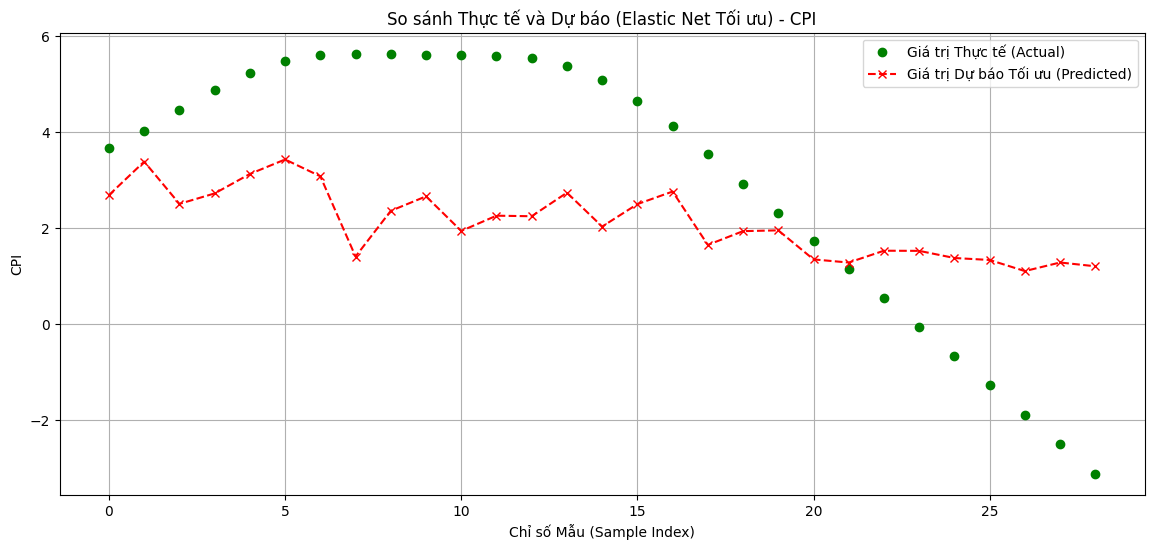

In [ ]:
if 'best_enet_model' in locals() and best_enet_model is not None:
    plt.figure(figsize=(14, 6))

    # Lấy 100 điểm dữ liệu đầu tiên để biểu đồ dễ quan sát
    num_points_to_plot = min(100, len(y_test)) 

    plt.plot(y_test.values[:num_points_to_plot], label= 'Giá trị Thực tế (Actual)', color='green', marker='o', linestyle='None')
    plt.plot(y_pred_best[:num_points_to_plot], label='Giá trị Dự báo Tối ưu (Predicted)', color='red', linestyle='--', marker='x')

    plt.title(f'So sánh Thực tế và Dự báo (Elastic Net Tối ưu) - {target_col}')
    plt.xlabel('Chỉ số Mẫu (Sample Index)')
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Bỏ qua trực quan hóa do mô hình tối ưu chưa có.")

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- 0. KHỞI TẠO THƯ MỤC LƯU TRỮ ---
OUTPUT_DIR_FIGURE = '../results/figures'
OUTPUT_DIR_TABLE = '../results/tables'
os.makedirs(OUTPUT_DIR_FIGURE, exist_ok=True)
os.makedirs(OUTPUT_DIR_TABLE, exist_ok=True)


# --- ĐỊNH NGHĨA HÀM TÍNH METRICS ---
def calculate_mape(y_true, y_pred):
    """Tính Mean Absolute Percentage Error (MAPE)."""
    epsilon = 1e-6
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def calculate_rmsfe(y_true, y_pred):
    """Tính Root Mean Squared Forecast Error (RMSFE)."""
    return np.sqrt(mean_squared_error(y_true, y_pred))


# =========================================================================
# I. XỬ LÝ VÀ LƯU KẾT QUẢ ELASTIC NET
# =========================================================================

if 'best_enet_model' in locals() and best_enet_model is not None:
    # Tính toán Metrics
    mae_en = mean_absolute_error(y_test, y_pred_best)
    rmsfe_en = calculate_rmsfe(y_test, y_pred_best)
    mape_en = calculate_mape(y_test, y_pred_best)
    
    # 1. Tạo DataFrame kết quả EN
    results_data_en = {
        'Model': ['ElasticNet_Optimized'],
        'Alpha': [best_enet_model.alpha],
        'L1_Ratio': [best_enet_model.l1_ratio],
        'R-squared': [r2_best],
        'RMSE': [rmse_best],
        'RMSFE': [rmsfe_en],
        'MAE': [mae_en],
        'MAPE (%)': [mape_en],
        'Target_Variable': [target_col]
    }
    df_results_en = pd.DataFrame(results_data_en)
    
    # 2. Lưu Bảng EN vào thư mục 'table'
    table_filename_en = os.path.join(OUTPUT_DIR_TABLE, 'elasticnet_model_summary.csv')
    df_results_en.to_csv(table_filename_en, index=False)
    
    # 3. Lưu Biểu đồ EN vào thư mục 'figure'
    plt.figure(figsize=(16, 8))
    num_points_to_plot = min(len(y_test), 150)
    plt.plot(y_test.values[:num_points_to_plot], label='Thực tế', color='green', linewidth=2)
    plt.plot(y_pred_best[:num_points_to_plot], label='Dự báo EN', color='red', linestyle='--', alpha=0.8, linewidth=2)
    plt.title(f'Dự báo Elastic Net Tối ưu cho {target_col}')
    plt.xlabel('Chỉ số Quan sát'); plt.ylabel(target_col); plt.legend(); plt.grid(True)
    figure_filename_en = os.path.join(OUTPUT_DIR_FIGURE, 'elasticnet_forecast_plot.png')
    plt.savefig(figure_filename_en, bbox_inches='tight', dpi=300)
    plt.close()
    
    print(f"\n[Elastic Net] Đã lưu bảng metrics vào '{table_filename_en}'")
    print(f"[Elastic Net] Đã lưu biểu đồ vào '{figure_filename_en}'")
else:
    print("\n[Elastic Net] Bỏ qua vì mô hình chưa được huấn luyện hoặc tối ưu thành công.")
    df_results_en = pd.DataFrame() # Khởi tạo rỗng để sử dụng trong Cell 9

Đã tạo thư mục '../results/figures' và '../results/tables'.

[Elastic Net] Đã lưu bảng metrics vào '../results/tables\elasticnet_model_summary.csv'
[Elastic Net] Đã lưu biểu đồ vào '../results/figures\elasticnet_forecast_plot.png'
